In [2]:
import numpy as np
import cupy as cp


class TrapezoidGeometry:

    def __init__(self, xp=np, from_fitter=False):
        self.xp = xp
        self.from_fitter = from_fitter

    @staticmethod
    def calculate_shift(self, height, langle):
        """
        This method calculates how much the trapezoids are shifted in the z direction
        @param
        height: a list of floats containing height for each layer 
                of trapezoid or a float if all the layers have the same height
        langle: a 2d array of floats
        @return
        shift: a list with calculated shift values
        """
        if (height.ndim == 1):
            shift = height[:, self.xp.newaxis] * self.xp.arange(langle.shape[1])

        elif (height.shape == langle.shape):
            shift = self.xp.zeros_like(height)
            height_cumsum = self.xp.cumsum(height, axis=1)
            shift[:,1:] = height_cumsum[:,:-1]

        else:  
            raise ValueError('Height and langle should be compatible')

        return shift
    
    @staticmethod
    def calculate_coefficients(self, qzs, height, langle, weight):
        """
        @param
        qz: a list of floats
        height: a list of floats containing height for each layer 
                of trapezoid or a float if all the layers have the same height
        langle: a 2d array of floats
        weight: a list of floats or None
        @return
        coefficients: a 3d list of floats needed to calculate the form factor
        """

        qzs = qzs[self.xp.newaxis, self.xp.newaxis, ...]

        shift = self.calculate_shift(self, height, langle)
        coeff = self.xp.exp(-1j * shift[:,:, self.xp.newaxis] * qzs)

        if weight is not None:
            coeff *= weight[:, self.xp.newaxis] * (1. + 1j)

        return coeff
    
    @staticmethod
    def calculate_ycoords(self, height, langle, rangle, y1, y2):
        """
        @param
        height: a list of floats containing height for each layer 
                of trapezoid or a float if all the layers have the same height
        langle: a 2d array of floats
        rangle: a 2d array of floats
        y1: a list of floats
        y2: a list of floats
        @return
        y1, y2: a 2d array of floats
        """                            
        
        #modify y1 and y2 to match the shape of langle and rangle
        y1 = y1[..., self.xp.newaxis] * self.xp.ones_like(langle)
        y2 = y2[..., self.xp.newaxis] * self.xp.ones_like(langle)

        #calculate y1 and y2 for each trapezoid cumilatively using cumsum but need to preserve the first values
        #/!\ for 90 degrees, tan(90deg) is infinite so height/tan(90deg) is equal to the zero upto the precision of 10E-14 only
        y1_cumsum = self.xp.cumsum(height / self.xp.tan(langle), axis=1)
        y2_cumsum = self.xp.cumsum(height / self.xp.tan(np.pi - rangle), axis=1)

        y1[:,1:] = y1[:,1:]  +  y1_cumsum[:,:-1]
        y2[:,1:] = y2[:,1:]  + y2_cumsum[:,:-1]

        return y1, y2

    @staticmethod
    def trapezoid_form_factor(self, qys, qzs, y1, y2, langle, rangle, height):

        """
        Simulation of the form factor of a trapezoid at all qx, qz position.
        Function extracted from XiCam

        Parameters
        ----------
        qys, qzs: numpy or cupy array of floats
            List of qx/qz at which the form factor is simulated
        y1, y2: numpy or cupy array of floats
            Values of the bottom right/left (y1/y2) position respectively of
            the trapezoids such as y2 - y1 = width of the bottom of the trapezoids
        langle, rangle: numpy or cupy 2d array of floats
            Left and right bottom angle of trapezoid
        height: numpy or cupy of floats
            Height of the trapezoid

        Returns
        -------
        form_factor: numpy or cupy 2d array of floats
            List of the values of the form factor
        """
        tan1 = self.xp.tan(langle)[:,:, self.xp.newaxis]
        tan2 = self.xp.tan(np.pi - rangle)[:,:, self.xp.newaxis]
        val1 = qys + tan1 * qzs
        val2 = qys + tan2 * qzs
        with np.errstate(divide='ignore'):
            form_factor = (tan1 * self.xp.exp(-1j * qys * y1[:,:, self.xp.newaxis]) *
                        (1 - self.xp.exp(-1j * height[:,:, self.xp.newaxis] / tan1 * val1)) / val1)
            form_factor -= (tan2 * self.xp.exp(-1j * qys * y2[:,:, self.xp.newaxis]) *
                            (1 - self.xp.exp(-1j * height[:,:, self.xp.newaxis] / tan2 * val2)) / val2)
            form_factor /= qys

        return form_factor
    
    @staticmethod
    def corrections_dwi0bk(self, intensities, dw_factorx, dw_factorz,
                       scaling, bkg_cste, qxs, qzs):
        """
        Apply corrections to the form factor
        @param
        intensities: a 2d array of floats
        dw_factorx: a float
        dw_factorz: a float
        """

        qxs = qxs[..., self.xp.newaxis]
        qzs = qzs[..., self.xp.newaxis]

        dw_array = self.xp.exp(-(qxs * dw_factorx) ** 2 +
                            (qzs * dw_factorz) ** 2)

        intensities_corr = (self.xp.asarray(intensities).T * dw_array * scaling
                                + bkg_cste)
        return intensities_corr.T
    
    def calculate_form_factor(self, qys, qzs, params):
        """
        @param
        params: a dictionary containing all the parameters needed to calculate the form factor
        @return
        form_factor: a 1d array of floats
        """
        height = params['height']
        langle = params['langles']
        rangle = params.get('rangles', langle)#if rangle is not in the dictionary set it to langle
        y1_initial = params['y1']
        y2_initial = params['bot_cd']
        weight = params.get('weight', None)#check if weight is in the dictionary if not set it to None

        #making sure all the inputs are arrays
        if not isinstance(height, self.xp.ndarray):
            height = self.xp.asarray(height)
        if not isinstance(qys, self.xp.ndarray):
            qys = self.xp.asarray(qys)
        if not isinstance(qzs, self.xp.ndarray):
            qzs = self.xp.asarray(qzs)
        if not isinstance(langle, self.xp.ndarray):
            langle = self.xp.asarray(langle)
        if not isinstance(rangle, self.xp.ndarray):
            rangle = self.xp.asarray(rangle)
        if not isinstance(y1_initial, self.xp.ndarray):
            y1_initial = self.xp.asarray(y1_initial)
        if not isinstance(y2_initial, self.xp.ndarray):
            y2_initial = self.xp.asarray(y2_initial)
        if weight and not isinstance(weight, self.xp.ndarray):
            weight = self.xp.asarray(weight)

        if not (height.shape == langle.shape):
            height = height[..., self.xp.newaxis]#needs to be of same dimension as langles
       

        y1, y2 = self.calculate_ycoords(self, height=height, langle=langle, rangle=rangle, y1=y1_initial, y2=y2_initial)

        form_factor = self.trapezoid_form_factor(self, qys=qys, qzs=qzs, y1=y1, y2=y2, langle=langle, rangle=rangle, height=height)

        return form_factor

    
    def correct_form_factor_intensity(self, qys, qzs, params):
        """
        @param
        params: a dictionary containing all the parameters needed to calculate the form factor
        @return
        form_factor_intensity: a 2d array of floats
        """

        #if the parameters not from Fitter class check params and correct if needed
        if not self.from_fitter:
            params = self.check_params(params)

        height = params['height']
        langle = params['langles']
        rangle = params.get('rangles', langle)#if rangle is not in the dictionary set it to langle
        weight = params.get('weight', None)#check if weight is in the dictionary if not set it to None

        #making sure all the inputs are arrays
        if not isinstance(height, self.xp.ndarray):
            height = self.xp.asarray(height)
        if not isinstance(qys, self.xp.ndarray):
            qys = self.xp.asarray(qys)
        if not isinstance(qzs, self.xp.ndarray):
            qzs = self.xp.asarray(qzs)
        if not isinstance(langle, self.xp.ndarray):
            langle = self.xp.asarray(langle)
        if not isinstance(rangle, self.xp.ndarray):
            rangle = self.xp.asarray(rangle)
        if weight and not isinstance(weight, self.xp.ndarray):
            weight = self.xp.asarray(weight)

        coeff = self.calculate_coefficients(self, qzs=qzs, height=height, langle=langle, weight=weight)
        form_factor = self.xp.sum(self.calculate_form_factor(qys=qys, qzs=qzs, params=params)*coeff, axis=1)
        
        form_factor_intensity = self.xp.absolute(form_factor) ** 2

        dwx = params['dwx']
        dwz = params['dwz']
        i0 = params['i0']
        bkg_cste = params['bkg_cste']

        corrected_intensity = self.corrections_dwi0bk(self, intensities=form_factor_intensity, dw_factorx=dwx, dw_factorz=dwz, scaling=i0, bkg_cste=bkg_cste, qxs=qys, qzs=qzs)
        
        return corrected_intensity
    
    def check_params(self, params):
        """
        @param
        params: a dictionary containing all the parameters needed to calculate the form factor
        @return
        params: a dictionary containing all the parameters needed to calculate the form factor
        """

        #check if all the required parameters are in the dictionary
        if 'height' not in params:
            raise ValueError('Height is required')
        if 'langles' not in params:
            raise ValueError('Left angles are required')
        if 'y1' not in params:
            raise ValueError('Y1 is required')
        if 'bot_cd' not in params:
            raise ValueError('Bottom center distance is required')
        if 'dwx' not in params:
            raise ValueError('Dwx is required')
        if 'dwz' not in params:
            raise ValueError('Dwz is required')
        if 'i0' not in params:
            raise ValueError('I0 is required')
        if 'bkg_cste' not in params:
            raise ValueError('Background constant is required')
        
        #handle the non required parameters
        if 'rangles' not in params:
            params['rangles'] = params['langles']
        if 'weight' not in params:
            params['weight'] = None
        
        #making sure that height is a 1d or 2d array and angles are 2d arrays
        height = params['height']
        langle = self.xp.asarray(params['langles'])
        rangle = self.xp.asarray(params['rangles'])

        if isinstance(height, float):
            params['height'] =  self.xp.asarray([height])
        elif isinstance(height, list):
            params['height'] = self.xp.asarray([height])
        else:
            raise ValueError('Height should be a float or a list')

        if langle.ndim == 1 or rangle.ndim == 1:
            params['langles'] = [langle]
            params['rangles'] = [rangle]
        elif langle.ndim != 2 or rangle.ndim != 2:
            raise ValueError('Left angles and right angles should be a 1d list or a list of lists')
    


        return params

 ## Test

In [3]:
##################################TESTING############################################
pitch = 100 #nm distance between two trapezoidal bars
qzs = np.linspace(-0.1, 0.1, 120)
qxs = 2 * np.pi / pitch * np.ones_like(qzs)

# Define initial parameters and multiples

#Example of data entered by the user
dwx = 0.1
dwz = 0.1
i0 = 10
bkg = 0.1
height = [23.48, 23.48] #here the each number represents the height of each layer of trapezoid
bot_cd = [54.6]
swa = [85, 82]

langle = np.deg2rad(np.asarray(swa))
rangle = np.deg2rad(np.asarray(swa))

params1 = {'height': height,
           'langles': langle, 
           'rangles': rangle,
           'y1': 0, 
           'bot_cd': bot_cd,  
           'dwx': dwx, 
           'dwz': dwz, 
           'i0': i0, 
           'bkg_cste': bkg}

#Example of data arriving from From fitter class
dwx2 = 0.1
dwz2 = 0.1
i02 = 10
bkg2 = 0.1
height2 = [[23.48, 23.45], [23.48, 23.45]]#here each inner list represents the heights of one population of trapezoids, if it is a constant such as [23.45, 23.48] then for one population the heights are constant
bot_cd2 = [54.6, 54.2]
swa2 = [[85, 82],[87, 85]]

langle2 = np.deg2rad(np.asarray(swa2))
rangle2 = np.deg2rad(np.asarray(swa2))

params2 = {'height': height2,
              'langles': langle2, 
              'rangles': rangle2,
              'y1': 0, 
              'bot_cd': bot_cd2,  
              'dwx': dwx2, 
              'dwz': dwz2, 
              'i0': i02, 
              'bkg_cste': bkg2}

Trapezoid1 = TrapezoidGeometry(np)


Trapezoid2 = TrapezoidGeometry(np, from_fitter=True)


form_factor1 = Trapezoid1.correct_form_factor_intensity(qys=qxs, qzs=qzs, params=params1)
form_factor2 = Trapezoid2.correct_form_factor_intensity(qys=qxs, qzs=qzs, params=params2)

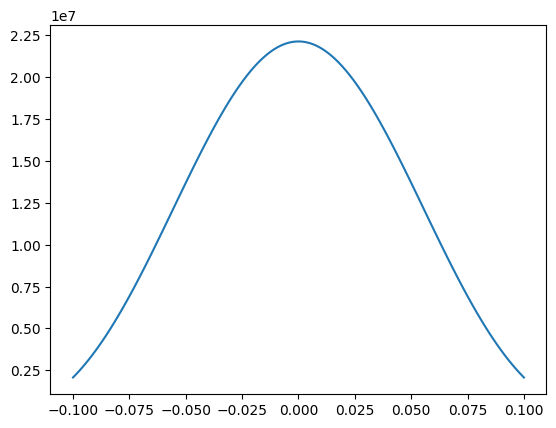

In [4]:
import matplotlib.pyplot as plt

plt.plot(qzs, form_factor1[0])

## Testing for StackedTrapezoiSimulation class

In [5]:
##################################TESTING############################################

pitch = 100 #nm distance between two trapezoidal bars
qzs = np.linspace(-0.1, 0.1, 20)
qxs = 2 * np.pi / pitch * np.ones_like(qzs)

# Define initial parameters and multiples

#Initial parameters
dwx = 0.1
dwz = 0.1
i0 = 10
bkg = 0.1
y1 = 0
height = [23.48]
bot_cd = 54.6
swa = [85]

langle = np.deg2rad(np.asarray(swa))
rangle = np.deg2rad(np.asarray(swa))

params1 = {'heights': {'value': height, 'variation': 10E-5},
            'langles': {'value': langle, 'variation': 10E-5},
            'rangles': {'value': None, 'variation': 10E-5},
            'y1': {'value': y1, 'variation': 10E-5},
            'bot_cd': {'value': bot_cd, 'variation': 10E-5},
            'dwx': {'value': dwx, 'variation': 10E-5},
            'dwz': {'value': dwz, 'variation': 10E-5},
            'i0': {'value': i0, 'variation': 10E-5},
            'bkg_cste': {'value': bkg, 'variation': 10E-5}
            }

#simulated fit data from fitter
fitparams = [[10, 10, 10, 10, 10, 10, 10, 10 ],
             [10, 10, 10, 10, 10, 10, 10, 10 ]
             ]

#with fitter
Simulation = StackedTrapezoidSimulation(qys=qxs, qzs=qzs, xp=np, form_fitter=True, initial_guess=params1)

intensity = Simulation.simulate_diffraction(fitparams=fitparams)


#without fitter

params1 = {'heights': height,
            'langles': langle,
            'rangles': rangle,
            'y1': y1,
            'bot_cd': bot_cd,
            'dwx': dwx,
            'dwz': dwz,
            'i0': i0,
            'bkg_cste': bkg
            }

Simulation = StackedTrapezoidSimulation(xp=np, qys=qxs, qzs=qzs, form_fitter=False)

intensity = Simulation.simulate_diffraction(params=params1)

NameError: name 'StackedTrapezoidSimulation' is not defined

### Testing extract_params

In [ ]:
height, langle, rangle, y1_initial, y2_initial, weight, dwx, dwz, i0, bkg_cste = Simulation.TrapezoidGeometry.extract_params(fitparams=fitparams)

## Testing For Residual Class

In [ ]:

####################################TESTING####################################
pitch = 100 #nm distance between two trapezoidal bars
qzs = np.linspace(-0.1, 0.1, 20)
qxs = 2 * np.pi / pitch * np.ones_like(qzs)

# Define initial parameters and multiples

#Initial parameters
dwx = 0.1
dwz = 0.1
i0 = 10
bkg = 0.1
y1 = 0
height = [23.48]
bot_cd = 54.6
swa = [85]

langle = np.deg2rad(np.asarray(swa))
rangle = np.deg2rad(np.asarray(swa))

#simulate data
params = {'heights': height,
            'langles': langle,
            'rangles': rangle,
            'y1': y1,
            'bot_cd': bot_cd,
            'dwx': dwx,
            'dwz': dwz,
            'i0': i0,
            'bkg_cste': bkg
            }

Simulation1 = StackedTrapezoidSimulation(xp=np, qys=qxs, qzs=qzs, form_fitter=False)

intensity = Simulation1.simulate_diffraction(params=params)

#fit the data
params1 = {'heights': {'value': height, 'variation': 10E-5},
            'langles': {'value': langle, 'variation': 10E-5},
            'rangles': {'value': None, 'variation': 10E-5},
            'y1': {'value': y1, 'variation': 10E-5},
            'bot_cd': {'value': bot_cd, 'variation': 10E-5},
            'dwx': {'value': dwx, 'variation': 10E-5},
            'dwz': {'value': dwz, 'variation': 10E-5},
            'i0': {'value': i0, 'variation': 10E-5},
            'bkg_cste': {'value': bkg, 'variation': 10E-5}
            }

#simulated fit data from fitter
fitparams = [[10, 10, 10, 10, 10, 10, 10, 10 ],
             [10, 10, 10, 10, 10, 10, 10, 10 ]
             ]

#with fitter
Simulation = StackedTrapezoidSimulation(qys=qxs, qzs=qzs, xp=np, form_fitter=True, initial_guess=params1)

Residual = PicklableResidual(data=intensity[0], fit_mode='cmaes', xp=np, Simulation=Simulation)

res = Residual(fitparams)

print(res)

[1, 1, 1, 1, 1]

In [4]:
import pandas as pd
import numpy as np

# Sample data
population_with_fitness = np.asarray([[1, 2, 3, 0.5], [4, 5, 6, 0.6], [7, 8, 9, 0.7]])  # Example data without brackets

# Create DataFrame
population_fr = pd.DataFrame(population_with_fitness)

print(population_fr)



     0    1    2    3
0  1.0  2.0  3.0  0.5
1  4.0  5.0  6.0  0.6
2  7.0  8.0  9.0  0.7


In [7]:
from cdsaxs_fitting.residual import Residual
from cdsaxs_fitting.simulations.stacked_trapezoid import StackedTrapezoidSimulation
import numpy as np

pitch = 100 #nm distance between two trapezoidal bars
qzs = np.linspace(-0.1, 0.1, 20)
qxs = 2 * np.pi / pitch * np.ones_like(qzs)

# Define initial parameters and multiples

#Initial parameters
dwx = 0.1
dwz = 0.1
i0 = 10
bkg = 0.1
y1 = 0
height = [23.48]
bot_cd = 54.6
swa = [85]

langle = np.deg2rad(np.asarray(swa))
rangle = np.deg2rad(np.asarray(swa))

#simulate data
params = {'heights': height,
            'langles': langle,
            'rangles': rangle,
            'y1': y1,
            'bot_cd': bot_cd,
            'dwx': dwx,
            'dwz': dwz,
            'i0': i0,
            'bkg_cste': bkg
            }

Simulation = StackedTrapezoidSimulation(qys=qxs, qzs=qzs)
intensity = Simulation.simulate_diffraction(params=params)



In [8]:
initial_params = {'heights': {'value': params['heights'], 'variation': 10E-5},
                    'langles': {'value': params['langles'], 'variation': 10E-5},
                    'rangles': {'value': params['rangles'], 'variation': 10E-5},
                    'y1': {'value': params['y1'], 'variation': 10E-5},
                    'bot_cd': {'value': params['bot_cd'], 'variation': 10E-5},
                    'dwx': {'value': params['dwx'], 'variation': 10E-5},
                    'dwz': {'value': params['dwz'], 'variation': 10E-5},
                    'i0': {'value': params['i0'], 'variation': 10E-5},
                    'bkg_cste': {'value': params['bkg_cste'], 'variation': 10E-5}
                    }

Simulation1 = StackedTrapezoidSimulation( qys=qxs, qzs=qzs, initial_guess=initial_params)
Simulation1.set_from_fitter(True)

residual = Residual(data=intensity, fit_mode='cmaes', Simulation=Simulation1)

res = residual([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

print(res)


[0.]


In [ ]:
from cdsaxs_fitting.fitter import Fitter
from cdsaxs_fitting.simulations.stacked_trapezoid import StackedTrapezoidSimulation
import numpy as np

### How to do a diffraction simulation using cdsaxs package?

#### Prepare the data

pitch = 100 #nm distance between two trapezoidal bars
qzs = np.linspace(-0.1, 0.1, 10)
qxs = 2 * np.pi / pitch * np.ones_like(qzs)

# Define initial parameters and multiples

#Initial parameters
dwx = 0.1
dwz = 0.1
i0 = 10
bkg = 0.1
y1 = 0.
height = [20.]
bot_cd = 40.
swa = [90.]

langle = np.deg2rad(np.asarray(swa))
rangle = np.deg2rad(np.asarray(swa))

#simulation data
i_params = {'heights': np.asarray(height),
            'langles': langle,
            'rangles': rangle,
            'y1': y1,
            'bot_cd': bot_cd,
            'dwx': dwx,
            'dwz': dwz,
            'i0': i0,
            'bkg_cste': bkg
            }

#### Create instance of the Simulation class and call right method

Simulation1 = StackedTrapezoidSimulation(qys=qxs, qzs=qzs)

intensity = Simulation1.simulate_diffraction(params=i_params)
## How to fit the data using cdsaxs package?

#### Prepare the data

initial_params = {'heights': {'value': height, 'variation': 10E-5},
                    'langles': {'value': langle, 'variation': 10E-5},
                    'rangles': {'value': rangle, 'variation': 10E-5},
                    'y1': {'value': y1, 'variation': 10E-5},
                    'bot_cd': {'value': bot_cd, 'variation': 10E-5},
                    'dwx': {'value': dwx, 'variation': 10E-5},
                    'dwz': {'value': dwz, 'variation': 10E-5},
                    'i0': {'value': i0, 'variation': 10E-5},
                    'bkg_cste': {'value': bkg, 'variation': 10E-5}
                    }

#### First create an instance of the Simulation class and pass it to the Fitter class along with data to fit

Simulation2 = StackedTrapezoidSimulation(use_gpu=False, qys=qxs, qzs=qzs, initial_guess=initial_params)

Fitter1 = Fitter(Simulation=Simulation2, exp_data=intensity)

#### Then call the fit method of the Fitter class that you want

cmaes = Fitter1.cmaes(sigma=100, ngen=10, popsize=10, mu=10, n_default=9, restarts=10, tolhistfun=10E-5, ftarget=10, restart_from_best=True, verbose=False, dir_save="./")
mcmc = Fitter1.mcmc(N=9, sigma = np.asarray([100] * 9), nsteps=1000, nwalkers=18)

